### Stranger Things 2: Organic Objects Under the Microscope - Starter Notebook

Welcome to the Stranger Sections: Part 2 Challenge. This a follow up to the Stranger Sections challenge in hosted in October 2023. For this challenge, you will be given a series of images with labels and without labels. There are 3 classes of interest in the images; liptinite, vitrinite, and inertinite. With the labeled images you will be asked to build a semantic segmentation model using machine learning/deep learning methods.

### Supplied Materials:

* Starter Notebook
* Training data: 87 images with segmentation mask labels (42 Liptinite, 27 Vitrinite, 22 Inertinite)
* Test data: 25 images
* Additional data: 8641 unlabeled images containing all 3 classes, as well as various minerals.
* ViT MAE Starter code for pre-training a vision transformer backbone.
* Checkpoint for ViT pre-trained on unlabeled images, 500 epochs, default settings in starter notebook
* `requirements.txt` for all required packages

### Data

The data for this challenge is comprised of a training dataset, a test dataset, and additional unlabeled data. The training dataset consists of 87 images with segmentation mask labels. These images from the training dataset will be split into 3 classes; 42 Liptinite, 20 Vitrinite, 15 Inertinite. Inertinite will have a label value equal to 1, Vitrinite will have a label value equal to 2, and Liptinite will have a label value equal to 3. It is important that your predicted classes match these values.  Please see the challenge page for additional discussion around organic petrology and the classes. The test dataset consists of 25 images without segmentation mask labels. The additional unlabeled data consists of 8641 images without segmentation mask labels. The additional unlabeled images contain all three classes for prediction, as well as other objects like pyrite minerals. All images have a shape of `(1024,1360)`, each with 3 channels. Training data labels are provided as numpy arrays. Participants are free to augment or preprocess the data as they see fit.

Please remember to include any packages used in the `requirements.txt` file included in the starter notebook folder.

In [2]:
# ONLY RUN THIS CELL ONCE
#!pip install -r requirements.txt

In [3]:
import numpy as np
from typing import Literal
import matplotlib.pyplot as plt
import PIL.Image as Image
from glob import glob

Download the data directly from the [challenge page](https://thinkonward.com/app/c/challenges/stranger-sections-2), or using `wget` below.

In [4]:
# UNCOMMENT TO DOWNLOAD THE DATA AND MODEL CHECKPOINT
# !wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/stranger-sections-2/stranger-sections-2-train-data.zip #training data
# !wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/stranger-sections-2/stranger-sections-2-test-data.zip #testing data
# !wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/stranger-sections-2/stranger-sections-2-unlabeled-data.zip #unlabeled data

# !wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/stranger-sections-2/stranger_sections_pretrained_ViT_B_16_256.pth #model checkpoint

Load the Image and Label pair using `PIL` and `Numpy`

In [6]:
img = np.asarray(Image.open('./example_images/images/vyqade.JPG'))
label = np.load('./example_images/labels/vyqade_gt.npy')

Inspect shapes of images and labels

In [7]:
print(f'Shape of image: {img.shape}')
print(f'Shape of label: {label.shape}')

Shape of image: (1024, 1360, 3)
Shape of label: (1024, 1360)


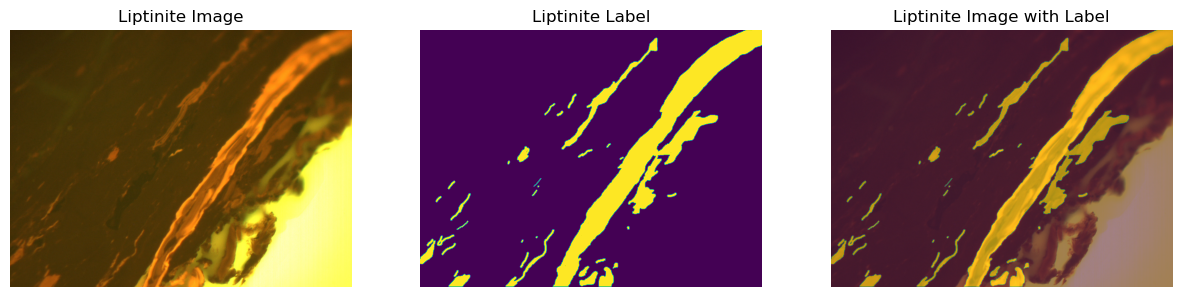

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[0].set_title('Liptinite Image')
ax[0].axis('off')
ax[1].imshow(label)
ax[1].set_title('Liptinite Label')
ax[1].axis('off')
ax[2].imshow(img)
ax[2].set_title('Liptinite Image with Label')
ax[2].axis('off')
ax[2].imshow(label, alpha=0.5)
plt.show()

### Vision Transformer Using Masked Autoencoders

Vision Transformers have proven to be a powerful technology when dealing with data rich and label poor disciplines. One of the biggest hurdles that data scientists face when building a model is the availabilty of accurately labeled training datasets. High quality labels require a lot of time from a subject matter expert, and money to compensate that individual for their work. Geology and Geophysics are great candidates for leveraging Vision Transformers to perform geoscience specific downstream tasks, like semantic segmentation.

The Onward Team has built our own Vision Transformer code base intented to help challengers pretrain a model backbone. **The code below is not intended to be the solution to the problem, but a starting point.** Challengers are free to use any Machine Learning/Deep Learning approach they see fit to train and segment images. Some examples could be [SAM](https://github.com/facebookresearch/segment-anything), [SegFormer](https://github.com/NVlabs/SegFormer), or a customized fine-tuning module built on top of the pre-training code provided. **Our hope with providing a method to pretrain a Vision Transformer is to take advantage of the unlabeled data to aid in the segmentation of our training and test data.** 

#### Pre-train ViT_B_16 model with Stranger Sections 2 dataset
The goal of pre-training the Vision Transformer is to completely repurpose it to work on the images provided in the challenge. To achieve this goal we can take two approaches:
 - start with a ViT checkpoint pretrained on the ImageNet dataset and train the model on the image data provided up to the point where attention maps are completely overwritten.
 - re-initialize all of the model parameters and train the ViT model from scratch.

The main steps performed by Masked Autoencoder architecture for each training image are: 
1. Mask a significant part of input image.
2. Feed the ViT encoder with visible (non-masked) patches.
3. Add mask tokens to the encoder output.
4. Use a full set of encoded patches and mask tokens to reconstruct the original image using a lightweight encoder.

After training is completed, the decoder can be discarded and the trained encoder is applied on full, unmasked images.

In this part we will cover pretraining of the ViT_B_16 model. The first approach uses a high-level interface included in the `masked_autoencoder.pretrain` module.

The dataset constructor within `pretrain.py` utilizes `torchvision.datasets.ImageFolder()` to create an unlabeled Pytorch dataset. This expects the following structure of your dataset directory:
 ```
 dataset
 ├── image_id_1.JPG
 ├── image_id_2.JPG
 ├── image_id_3.JPG
 └── image_id_4.JPG
 ```

 We have also provided a customized `dataset.py` script to be used to create a labeled training dataset for finetuning.

In [ ]:
import sys

sys.path.append("masked_autoencoder")
from masked_autoencoder.pretrain import pretrain_mae
from utils import plot_report

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

In [ ]:
# Data in your dataset catalog should contain 3D numpy arrays stored as `.npy` files. We recommend to start with data from Patch the Planet challange.
dataset = "./data/unlabeled_images/"

# We will start with default torchvision checkpoint - pretrained on ImageNet1k data
history = pretrain_mae(
    dataset,  # your checkpoint will be saved to this location - catalog must exist before training!
    output="checkpoints/ViT_B_16_stranger_sections2.pth",
    transform_kwargs={
        "min_scale": 0.33,
        "normalize": False,
    },  # this will be passed to lightly.transforms.mae_transform.MAETransform
    vit_model="ViT_B_16",
    starting_weights="ViT_B_16_Weights.DEFAULT",
    batch_size=64,
    n_workers=8,  # to achieve best performance we recommend setting this value to match number of physical cores of your CPU
    optimizer="SGD",  # AdamW and SGD are supported out of the box
    optimizer_kwargs={
        "lr": 1e-4,
        "momentum": 0.0,
    },  # this will be passed to optimizer constructor
    warmup_epochs=20,  # tune Learning Rate schedules to match your needs
    start_factor=0.2,  # starting decrease factor for warmup
    linear_schedule=True,
    end_factor=0.5,  # final decrease factor for LR schedule
    n_epochs=200,  # number of non-warmup training epochs
    masking_rate=0.75,  # define what share of input image will be masked
    decoder_dim=256,  # we will use smaller decoder as we're training the smallest model of ViT family
    freeze_projection=False, # we will start with trainig whole model
    freeze_embeddings=False,
)  

In [ ]:
plot_report(history, x_locator_tick=2)

#### Running a pretrain job with the shell call
In order to call a batch job from the notebook you can use following call - to learn more about CLI usage of the module read the README file inside the masked_autoencoder module or call `python 'masked_autoencoder/pretrain.py' --help`

Note that when using CLI the training report will be automatically saved as a JSON file `your_checkpoint_name_report.json`

In [ ]:
 !python 'masked_autoencoder/pretrain.py' ./path/to/your/data \
 --vit-model ViT_B_16 --starting-weights ViT_B_16_Weights.DEFAULT \
 --output checkpoints/seismic_model.pth --batch-size 256 --n-epochs 10 \
 --optimizer SGD --lr 1e-4 --linear-schedule \
 --freeze-projection --freeze-embeddings

#### Fine-tune ViT checkpoint 
Unlike pre-training, the main purpose of fine-tuning is to slowly modify the parameters of a pre-trained model to catch dataset-specific features and improve generalization capabilities. Fine-tuning for segmentation requires a specific Decoder and segmentation head to achieve successful results for this challenge. We encourage you to review the [SegFormer](https://github.com/NVlabs/SegFormer) model and architecture to understand how to build out this type of model. An informative step by step breakdown of SegFormer can be found [here](https://github.com/FrancescoSaverioZuppichini/SegFormer).

### Solution

In [6]:
%%time
# YOUR SOLUTION HERE

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.01 µs


### Evaluation

To evaluate the performance of your solution you will need to submit segmentation masks for the 25 test images, found on the Onward website under the Challenge Data Tab. For this challenge, a Dice Coefficient or Jaccard Score is the primary metric to assess the accuracy of your model. The live scoring algorithm uses the scikit-learn implementation of `jaccard_score()` with `average="micro"`. For more information on the scoring algorithm check it out [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html). 

Please note that the submission file naming convention must be used for the scoring algorithm to work correctly. Each image has a unique 6 character id for its name. It is important that when you create predictions for the images, the predictions are labeled in this format: `<image_id>_pred.npy`. For example, predictions for `1knjzt.JPG, 20di1f.JPG...ont2xr.JPG` must be named as `1knjzt_pred.npy, 20di1f_pred.npy...ont2xr_pred.npy` files, respectively. Once you have completed your predictions compress the files using `zip` and submit on challenge homepage.  The Data Tab has a sample submission file for the Test Data set. The example submission file provided on the Data Tab is purely for your reference, it is not to be used in your prediction pipeline. Each submission file must contain a segmentation mask for the whole image - make sure that dimensions of your predictions match the shape of the test images.